In [10]:
#%% parse file (state, action, reward)
import pandas

dataframe = pandas.read_csv('Ass4Data.txt', header=None, sep='\s',names=['state','action','reward'], engine='python')
print(dataframe.head())

states = dataframe.state.unique()
actions = dataframe.action.unique()
states_and_actions = dataframe[['state','action']].drop_duplicates().sort_values(by='state')
states.sort()
actions.sort()

print("States: {}".format(states))
print("Actions".format(actions))


   state  action  reward
0      1       2  10.194
1      8       3   0.720
2      4       3  15.665
3      8       1  13.230
4      6       3   6.005
States: [1 2 3 4 5 6 7 8]
Actions


In [2]:
from pprint import pprint
from matplotlib import pyplot as plt
from tqdm import tqdm
# Off policy MC control

def Off_Policy_MC_Control(dataframe,states,actions,gamma):
    # Initialize Q, C and Pi
    Q = {(s,a):0 for s in states for a in actions}
    C = {(s,a):0 for s in states for a in actions}
    Pi = {s:a for s in states for a in actions if max([Q[s,at] for at in actions])==Q[s,a]} # Breaking ties should be consistent

    G = 0
    W = 1

    Sum_Q_values = [0]
    record_period = 10000
    # For the episode generated using equiprobable policy
    for step in tqdm(range(dataframe.shape[0]-1,-1,-1)): # to iterate from T-1 to 0 (dataframe.shape[0]-1,-1,-1))
        # Read the MDP step from the record
        (s,a,r1) = dataframe.iloc[step].values.tolist()
        #print("state:{}\taction:{}\treward:{}".format(s,a,r1))

        G = gamma*G + r1
        C[s,a] = C[s,a] + W
        Q[s,a] = Q[s,a] + (W/(C[s,a]))*(G - Q[s,a])
        Pi[s] = [at for at in actions if max([Q[s,att] for att in actions])==Q[s,at]][0]
        #pprint([Q[s,at] for at in actions])
        #pprint(max([Q[s,at] for at in actions]))
        #pprint([at for at in actions if max([Q[s,att] for att in actions])==Q[s,at]])
        #print(Pi[s])
        if step%record_period==0:
            #print(step)
            #print([Pi[st] for st in states])
            #print([Q[st,at] for st in states for at in actions])
            Sum_Q_values.append(sum([Q[st,at] for st in states for at in actions]))

        # If A is not equal to Pi[s] then break the chain
        if (Pi[s] != a):
            # Reset G and W
            #print("reset")
            G = 0
            W = 1
        else:
            W = W*(1/(1/3)) # 1/3 as the policy is equiprobable



    plt.plot([i for i in range(0,dataframe.shape[0]+record_period,record_period)],Sum_Q_values,linewidth=1, label='Sum of Q values')
    plt.xlabel('steps')
    plt.ylabel('Sum of Q Values')
    plt.title('Sum of Q Value variation for all states and actions ($\gamma$ = {})'.format(gamma))
    plt.show()

    print("Final policy:")
    pprint(Pi)
    print("Value of the policy:")
    pprint({st:Q[st,Pi[st]] for st in states})

    return Pi,Q




In [3]:
# Evaluating a policy Pi
def Off_Policy_MC_Prediction(dataframe,states,actions,gamma,Pi):
    print("Evaluating policy:")
    pprint(Pi)
    #print("Rearranging Pi format:")
    Pi_f = {(s,a):0 for s in states for a in actions}
    for t in Pi.keys():
        Pi_f[t,Pi[t]] = 1
    #pprint(Pi_f)

    # Initialize Q, C and Pi
    Q = {(s,a):0 for s in states for a in actions}
    C = {(s,a):0 for s in states for a in actions}

    G = 0
    W = 1

    Sum_Q_values = [0]
    record_period = 10000
    # For the episode generated using equiprobable policy
    for step in tqdm(range(dataframe.shape[0]-1,-1,-1)): # to iterate from T-1 to 0 (dataframe.shape[0]-1,-1,-1))
    
        # Read the MDP step from the record
        (s,a,r1) = dataframe.iloc[step].values.tolist()
        #print("state:{}\taction:{}\treward:{}".format(s,a,r1))

        G = gamma*G + r1
        C[s,a] = C[s,a] + W
        Q[s,a] = Q[s,a] + (W/(C[s,a]))*(G - Q[s,a])
        
        if step%record_period==0:
            #print(step)
            #print([Pi[st] for st in states])
            #print([Q[st,at] for st in states for at in actions])
            Sum_Q_values.append(sum([Q[st,at] for st in states for at in actions]))

        W = W*(Pi_f[s,a]/(1/3)) # 1/3 as the policy is equiprobable

        # If W = 0 reset G and W
        if W == 0:
            G = 0
            W = 1

    plt.plot([i for i in range(0,dataframe.shape[0]+record_period,record_period)],Sum_Q_values,linewidth=1, label='Sum of Q values')
    plt.xlabel('steps')
    plt.ylabel('Sum of Q Values')
    plt.title('Policy Evaluation convergence ($\gamma$ = {})'.format(gamma))
    plt.show()

    #pprint(Q)
    print("Value of the policy:")
    pprint({st:Q[st,Pi[st]] for st in states})

    return Q


100%|██████████| 1000001/1000001 [04:03<00:00, 4112.26it/s]


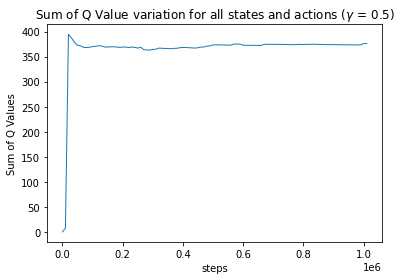

  0%|          | 881/1000001 [00:00<03:52, 4296.68it/s]Final policy:
{1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 2, 7: 3, 8: 2}
Value of the policy:
{1: 17.383464392394586,
 2: 16.699999656671046,
 3: 18.732689485391244,
 4: 17.451868524166205,
 5: 20.05373938900274,
 6: 13.814681880793527,
 7: 18.002093377175253,
 8: 21.88343662099608}
Evaluating policy:
{1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 2, 7: 3, 8: 2}
100%|██████████| 1000001/1000001 [03:51<00:00, 4324.16it/s]


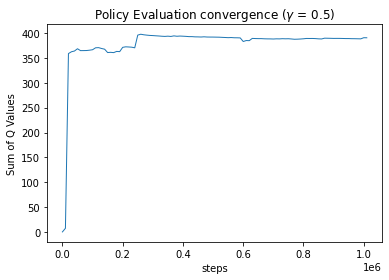

{(1, 1): 16.130616358116544,
 (1, 2): 20.60154667930165,
 (1, 3): 18.10483941975463,
 (2, 1): 9.41082537742185,
 (2, 2): 12.592433057636685,
 (2, 3): 16.696107078257384,
 (3, 1): 13.937327108489185,
 (3, 2): 10.206390905646364,
 (3, 3): 19.185514871706413,
 (4, 1): 15.655683742965012,
 (4, 2): 13.810495542680163,
 (4, 3): 25.83568181999604,
 (5, 1): 16.225224535090025,
 (5, 2): 18.11207321431311,
 (5, 3): 21.352849166561437,
 (6, 1): 12.519227778036672,
 (6, 2): 11.116407805790415,
 (6, 3): 11.088328336060483,
 (7, 1): 16.622855869601516,
 (7, 2): 18.654590952058868,
 (7, 3): 17.272655645835655,
 (8, 1): 18.988131252842532,
 (8, 2): 23.97061201342476,
 (8, 3): 12.497453300570532}
Value of the policy:
{1: 18.10483941975463,
 2: 16.696107078257384,
 3: 19.185514871706413,
 4: 25.83568181999604,
 5: 21.352849166561437,
 6: 11.116407805790415,
 7: 17.272655645835655,
 8: 23.97061201342476}


In [4]:
# Question 2 : Finding the optimal policy for infinite horizon with gamma = 0.5
print('Question 2 : Finding the optimal policy for infinite horizon with gamma = 0.5')
gamma = 0.5
Pi_control,Q_control = Off_Policy_MC_Control(dataframe,states,actions,gamma)
Q_eval = Off_Policy_MC_Prediction(dataframe,states,actions,gamma,Pi_control)

100%|██████████| 1000001/1000001 [04:01<00:00, 4144.49it/s]


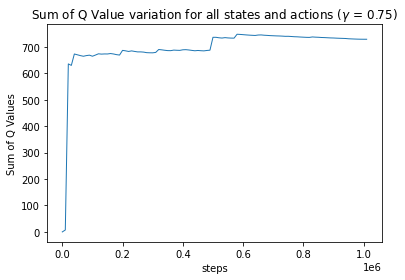

  0%|          | 900/1000001 [00:00<03:55, 4248.17it/s]Final policy:
{1: 3, 2: 3, 3: 1, 4: 3, 5: 2, 6: 2, 7: 3, 8: 2}
Value of the policy:
{1: 40.72288898516072,
 2: 24.69572311078934,
 3: 32.399179134868916,
 4: 37.18925758019225,
 5: 40.95047200351991,
 6: 37.09589542091785,
 7: 39.652432890450086,
 8: 40.243184154116406}
Evaluating policy:
{1: 3, 2: 3, 3: 1, 4: 3, 5: 2, 6: 2, 7: 3, 8: 2}
100%|██████████| 1000001/1000001 [03:27<00:00, 4819.77it/s]


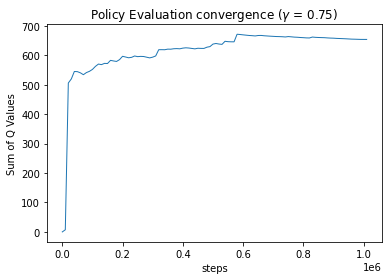

{(1, 1): 24.326013146664376,
 (1, 2): 39.02498997896071,
 (1, 3): 27.396742979708563,
 (2, 1): 19.926789224559606,
 (2, 2): 24.185402580795103,
 (2, 3): 24.820233631100105,
 (3, 1): 22.82163026827624,
 (3, 2): 26.725174927380657,
 (3, 3): 28.722964095551312,
 (4, 1): 26.299576011791284,
 (4, 2): 23.37893355688011,
 (4, 3): 37.87968504556974,
 (5, 1): 28.74806114496694,
 (5, 2): 31.47771493443946,
 (5, 3): 31.439520320922366,
 (6, 1): 22.596716620233487,
 (6, 2): 23.383681570478842,
 (6, 3): 21.308672097903145,
 (7, 1): 24.398470180804907,
 (7, 2): 26.790758717146705,
 (7, 3): 27.005181035102584,
 (8, 1): 34.46616284566806,
 (8, 2): 37.37816694355721,
 (8, 3): 19.651718978382426}
Value of the policy:
{1: 27.396742979708563,
 2: 24.820233631100105,
 3: 22.82163026827624,
 4: 37.87968504556974,
 5: 31.47771493443946,
 6: 23.383681570478842,
 7: 27.005181035102584,
 8: 37.37816694355721}


In [5]:
# Question 3 : Finding the optimal policy for infinite horizon with gamma = 0.5
print('Question 3 : Finding the optimal policy for infinite horizon with gamma = 0.75')
gamma = 0.75
Pi_control,Q_control = Off_Policy_MC_Control(dataframe,states,actions,gamma)
Q_eval = Off_Policy_MC_Prediction(dataframe,states,actions,gamma,Pi_control)

100%|██████████| 1000000/1000000 [07:37<00:00, 2186.57it/s]


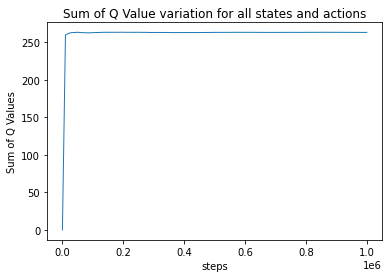

  0%|          | 280/1000000 [00:00<06:00, 2773.20it/s]Final policy:
{1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 2, 7: 3, 8: 2}
Value of the policy:
{1: 12.601790103665676,
 2: 9.722805387689776,
 3: 14.30944237562313,
 4: 14.278747166869993,
 5: 16.63449660236234,
 6: 6.021202763933,
 7: 14.506227887314642,
 8: 19.230977477984606}
Evaluating policy:
{1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 2, 7: 3, 8: 2}
100%|██████████| 1000000/1000000 [06:09<00:00, 2706.48it/s]


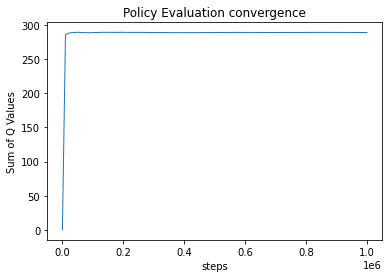

Value of the policy:
{1: 14.088714308437929,
 2: 10.985173450903174,
 3: 14.957574426607762,
 4: 16.132889850062814,
 5: 17.369467030104342,
 6: 6.021202763932977,
 7: 15.110135968815301,
 8: 21.233083385618258}


In [11]:
from tqdm import tqdm
from matplotlib import pyplot as plt
from pprint import pprint

# Problem 1 : Finite horizon problem
def Off_Policy_MC_Control_finite(dataframe,states,actions):
    # Initialize Q, C and Pi
    Q = {(s,a):0 for s in states for a in actions}
    C = {(s,a):0 for s in states for a in actions}
    Pi = {s:a for s in states for a in actions if max([Q[s,at] for at in actions])==Q[s,a]} # Breaking ties should be consistent


    Sum_Q_values = [0]
    record_period = 10000
    # For the episode generated using equiprobable policy
    for step in tqdm(range(dataframe.shape[0]-2,-1,-1)): # to iterate from T-1 to 0 (dataframe.shape[0]-1,-1,-1))
        G = 0
        W = 1
        # Read the MDP step from the record
        sar1 = dataframe.iloc[step].values.tolist()
        sar2 = dataframe.iloc[step+1].values.tolist()
        #print("state:{}\taction:{}\treward:{}\tnext_reward:{}".format(s,a,r1,r2))

        for (s,a,r) in [sar1,sar2]:
            G = G + r
            C[s,a] = C[s,a] + W
            Q[s,a] = Q[s,a] + (W/(C[s,a]))*(G - Q[s,a])
            Pi[s] = [at for at in actions if max([Q[s,att] for att in actions])==Q[s,at]][0]
            #pprint([Q[s,at] for at in actions])
            #pprint(max([Q[s,at] for at in actions]))
            #pprint([at for at in actions if max([Q[s,att] for att in actions])==Q[s,at]])
            #print(Pi[s])

            # If A is not equal to Pi[s] then break the chain
            if (Pi[s] != a):
                # Reset G and W
                #print("reset")
                G = 0
                W = 1
            else:
                W = W*(1/(1/3)) # 1/3 as the policy is equiprobable
        
        if step%record_period==0:
            Sum_Q_values.append(sum([Q[st,at] for st in states for at in actions]))

    plt.plot([i for i in range(0,dataframe.shape[0],record_period)],Sum_Q_values,linewidth=1, label='Sum of Q values')
    plt.xlabel('steps')
    plt.ylabel('Sum of Q Values')
    plt.title('Sum of Q Value variation for all states and actions')
    plt.show()

    print("Final policy:")
    pprint(Pi)
    print("Value of the policy:")
    pprint({st:Q[st,Pi[st]] for st in states})

    return Pi,Q

# Evaluating finite horizon policy Pi
def Off_Policy_MC_Prediction_finite(dataframe,states,actions,Pi):
    print("Evaluating policy:")
    pprint(Pi)
    #print("Rearranging Pi format:")
    Pi_f = {(s,a):0 for s in states for a in actions}
    for t in Pi.keys():
        Pi_f[t,Pi[t]] = 1
    #pprint(Pi_f)

    # Initialize Q, C and Pi
    Q = {(s,a):0 for s in states for a in actions}
    C = {(s,a):0 for s in states for a in actions}



    Sum_Q_values = [0]
    record_period = 10000
    # For the episode generated using equiprobable policy
    for step in tqdm(range(dataframe.shape[0]-2,-1,-1)): # to iterate from T-1 to 0 (dataframe.shape[0]-1,-1,-1))
    
        G = 0
        W = 1
        # Read the MDP step from the record
        sar1 = dataframe.iloc[step].values.tolist()
        sar2 = dataframe.iloc[step+1].values.tolist()

        for (s,a,r) in [sar1,sar2]:
            if W==0:
                break
            G = G + r
            C[s,a] = C[s,a] + W
            Q[s,a] = Q[s,a] + (W/(C[s,a]))*(G - Q[s,a])

            W = W*(Pi_f[s,a]/(1/3)) # 1/3 as the policy is equiprobable

        if step%record_period==0:
            Sum_Q_values.append(sum([Q[st,at] for st in states for at in actions]))

    plt.plot([i for i in range(0,dataframe.shape[0],record_period)],Sum_Q_values,linewidth=1, label='Sum of Q values')
    plt.xlabel('steps')
    plt.ylabel('Sum of Q Values')
    plt.title('Policy Evaluation convergence')
    plt.show()

    #pprint(Q)
    print("Value of the policy:")
    pprint({st:Q[st,Pi[st]] for st in states})

    return Q

Pi,Q = Off_Policy_MC_Control_finite(dataframe,states,actions)
Q_result = Off_Policy_MC_Prediction_finite(dataframe,states,actions,Pi)